In [158]:
import copy
import pandas as pd
import csv
import json
from lxml import etree
import os
from tqdm import tqdm
from collections import defaultdict
import statistics
import shutil
from azure.storage.blob import BlockBlobService
from eMammal_helpers import *

In [2]:
# print all outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# auto reload external Python modules
%load_ext autoreload
%autoreload 2

# display Matplotlib figures inline and set default size
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (8.0, 3.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 9

In [3]:
# configurations and paths
output_dir_path = '/home/yasiyu/yasiyu_temp'

deployments_path = '/datadrive/emammal'

projects_of_interest = ['p139', 'p158']  # the Robert Long collection had deployents from these two projects

# Prepare an iMerit job

This notebooks samples a subset of the Robert Long collection of eMammal data from the Seattle area, and 
copies them to a folder to hand off for annotations to iMerit.

Aim to have a sample of ~20k images:
- exclude empty sequences
- do not include too many humans
- reasonable diversity across species
- reasonable diversity across deployments
- balance between day/night (time of day is okay for this purpose)
- for simplicity, may avoid sequences with multiple _different_ species, since we'll use these labels for classification as well.
- could bias towards species that the GIX project needs

Image name format:

`dataset[datasetname].project[projectID].deployment[deploymentID].seq[sequenceID].frame[frameNumber].img[imageID].jpg
`

e.g.

`datasetemammal.project3062.deploymentd16546.seqd16546s14.frame001.imgd16546s14i1.jpg`

In [4]:
# find the deployments in the Robert Long collection

deployments = []
for deployment in os.listdir(deployments_path):
    # we know that for deployments in the Robert Long collection, the folders are prefixed with the 
    # project ID, but in general this is not true.
    of_interest = False
    for proj in projects_of_interest:
        if deployment.startswith(proj):
            of_interest = True
    if of_interest:
        deployments.append(deployment)

In [6]:
len(deployments)  # confirmed by using Storage Explorer that the 0Roboert Long collection has 126 zips indeed.

126

Make a dataframe, one row each sequence, columns include

`full_seq_id, project_id, deployment_id, species, is_empty, is_human_only, is_multi_species, num_frames, start_time, is_daytime`

species is semi-column separated list of unique species, sorted.

Make another dataframe for images, one row per image, columns include

`full_img_id, full_img_path, full_seq_id, project_id, project_name, deployment_id, site_name, species, img_id`

Note that `full_img_id` is generated from information in the xml file only, and you might not be able to construct `full_img_path` from it (hence the need for this mapping) because of errors in naming the folder structures.

Checked that all `full_img_path` exist on the data disk. Some images may be corrupted from previous experience.  

In [131]:
sequences_list = []
images_list = []
species_tally = defaultdict(int)

# is the species distribution different for sequences with no more than 20 frames
species_tally_short_seq = defaultdict(int)
max_num_frames = 20

for deployment in tqdm(deployments):
    deployment_path = os.path.join(deployments_path, deployment)
    manifest_path = os.path.join(deployment_path, 'deployment_manifest.xml')
    
    with open(manifest_path, 'r') as f:
        tree = etree.parse(f)
    
    root = tree.getroot()
    project_id = root.findtext('ProjectId')
    project_name = root.findtext('ProjectName')
    deployment_id = root.findtext('CameraDeploymentID')
    site_name = root.findtext('CameraSiteName')
    
    image_sequences = root.findall('ImageSequence')
    for sequence in image_sequences:
        images = sequence.findall('Image')
        num_frames = len(images)
        
        # sequences
        seq_id = sequence.findtext('ImageSequenceId')
        full_seq_id = 'datasetemammal.project{}.deployment{}.seq{}'.format(project_id, deployment_id, seq_id)
        
        # get species info
        researcher_identifications = sequence.findall('ResearcherIdentifications')
        species_in_seq = set()
        for researcher_id in researcher_identifications:
            identifications = researcher_id.findall('Identification')
            for id in identifications:
                species_common_name = clean_species_name(id.findtext('SpeciesCommonName'))
                species_tally[species_common_name] += 1
                species_in_seq.add(species_common_name)
                
                if num_frames <= max_num_frames:
                    species_tally_short_seq[species_common_name] += 1
                
        species_str = ';'.join(sorted(list(species_in_seq)))
    
        seq_start_time = sequence.findtext('ImageSequenceBeginTime')
        start_time = parse_timestamp(seq_start_time)
    
        sequences_list.append({
            'full_seq_id': full_seq_id,
            'project_id': project_id,
            'deployment_id': deployment_id,
            'species': species_str,
            'is_empty': True if species_str == 'empty' else False,
            'is_human_only': True if species_str == 'human' else False,
            'is_multi_species': True if len(species_in_seq) > 1 else False,
            'num_frames': num_frames,
            'start_time': start_time,
            'is_daytime': is_daytime(start_time)
        })
        
        # images
        for img in images:
            img_id = img.findtext('ImageId')
            img_file_name = img.findtext('ImageFileName')
            assert img_file_name.endswith('.JPG')
            try:
                img_frame = clean_frame_number_4_digit(img.findtext('ImageOrder'))
            except:
                img_frame = img_file_name.split('i')[1].split('.')[0]
                img_frame = clean_frame_number_4_digit(img_frame)
            
            full_img_id = 'datasetemammal.project{}.deployment{}.seq{}.frame{}.img{}'.format(project_id, deployment_id, seq_id, img_frame, img_id)
            full_img_path = os.path.join(deployment_path, img_file_name)
            
            if not os.path.exists(full_img_path):
                print('Path does not exist: {}'.format(full_img_path))
            
            images_list.append({
                'full_img_id': full_img_id,
                'full_img_path': full_img_path,
                'full_seq_id': full_seq_id,
                'project_id': project_id,
                'project_name': project_name,
                'deployment_id': deployment_id,
                'site_name': site_name,
                'species': species_str,
                'img_id': img_id
            })

100%|██████████| 126/126 [00:05<00:00, 22.46it/s]


Images in deployements `p139d18649` only have four attributes:

```
<Element Image at 0x7f0feeb07388>
<Element ImageId at 0x7f0feeb07288>
<Element ImageFileName at 0x7f0feeb07508>
<Element ImageInterestRanking at 0x7f0feebbf708>
```

Their frame number are assigned based on the image's file name.

In [8]:
len(sequences_list)

18604

In [133]:
len(images_list)

98486

### Species distribution in the 0Robert Long WA collection

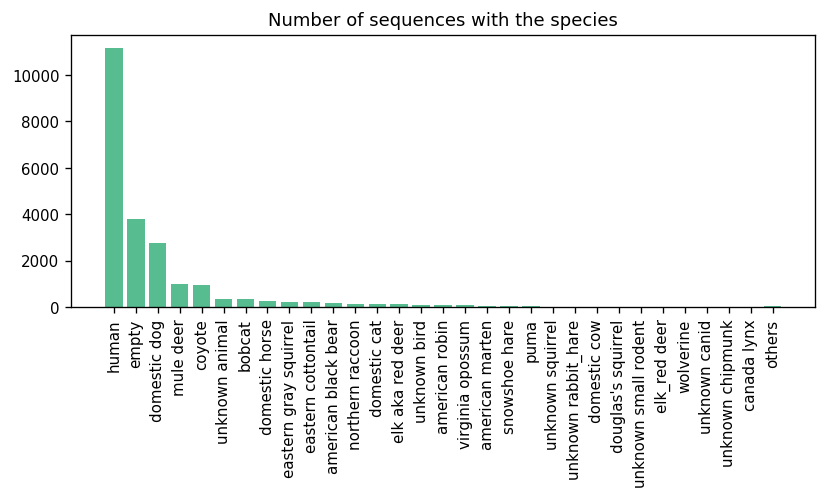

In [10]:
plot_distribution(species_tally, title='Number of sequences with the species', top=30)

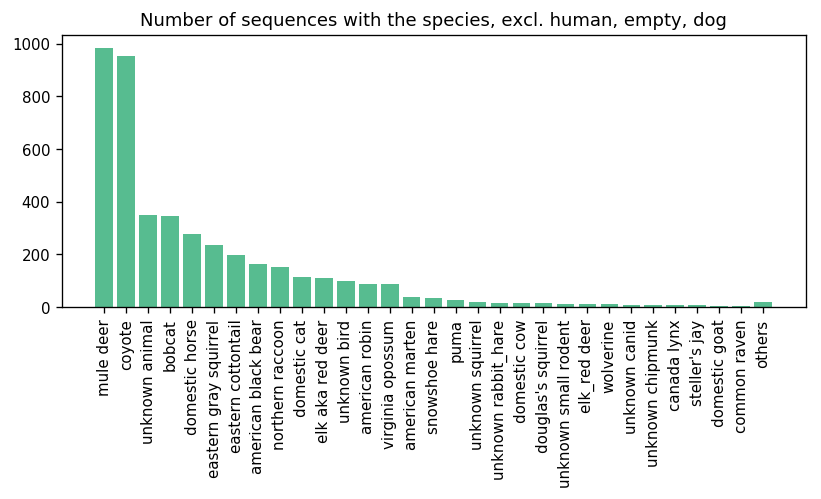

In [18]:
species_tally_animals = copy.deepcopy(species_tally)
species_tally_animals['human'] = 0
species_tally_animals['empty'] = 0
species_tally_animals['domestic dog'] = 0
plot_distribution(species_tally_animals, title='Number of sequences with the species, excl. human, empty, dog', top=30)

### Species distribution in the 0Robert Long WA collection, among sequences with 20 frames or fewer

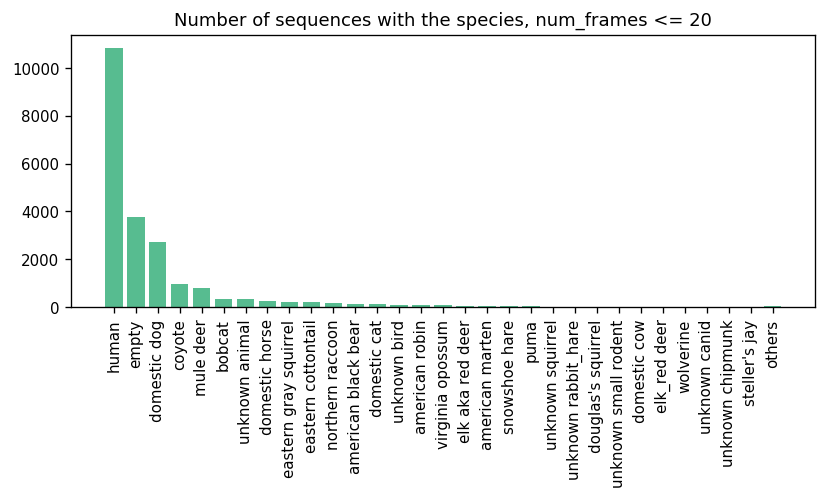

In [16]:
plot_distribution(species_tally_short_seq, title='Number of sequences with the species, num_frames <= 20', top=30)

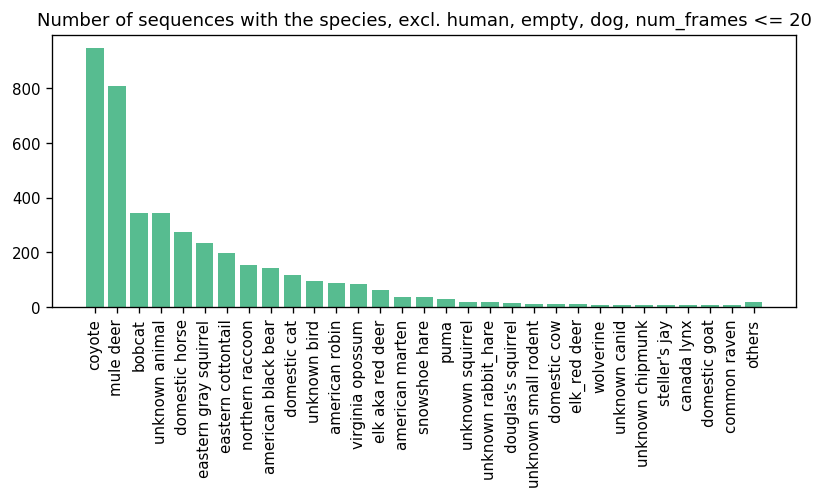

In [19]:
species_tally_animals = copy.deepcopy(species_tally_short_seq)
species_tally_animals['human'] = 0
species_tally_animals['empty'] = 0
species_tally_animals['domestic dog'] = 0
plot_distribution(species_tally_animals, title='Number of sequences with the species, excl. human, empty, dog, num_frames <= 20', top=30)

### Understand the distribution of species and number of frames

In [134]:
df_seq = pd.DataFrame(sequences_list)
df_img = pd.DataFrame(images_list)

In [70]:
len(df_seq)
df_seq.dtypes

18604

deployment_id               object
full_seq_id                 object
is_daytime                    bool
is_empty                      bool
is_human_only                 bool
is_multi_species              bool
num_frames                   int64
project_id                  object
species                     object
start_time          datetime64[ns]
dtype: object

In [71]:
len(df_img)

98486

In [72]:
df_seq.sample(n=5)

,deployment_id,full_seq_id,is_daytime,is_empty,is_human_only,is_multi_species,num_frames,project_id,species,start_time
7878,d34708,datasetemammal.projectp158.deploymentd34708.se...,False,False,False,False,2,p158,eastern cottontail,2016-10-21 23:22:05
1831,d34797,datasetemammal.projectp158.deploymentd34797.se...,True,False,True,False,9,p158,human,2017-04-08 11:49:15
13024,d34793,datasetemammal.projectp158.deploymentd34793.se...,True,False,False,True,6,p158,domestic dog;human,2017-02-22 07:47:02
5487,d34740,datasetemammal.projectp158.deploymentd34740.se...,True,False,False,True,1,p158,domestic dog;human,2016-10-23 14:33:37
12081,d34686,datasetemammal.projectp158.deploymentd34686.se...,True,False,True,False,1,p158,human,2016-08-26 10:34:30


In [73]:
df_img.sample(n=3)

,full_img_id,full_img_path,full_seq_id
18501,datasetemammal.projectp158.deploymentd34787.se...,/datadrive/emammal/p158d34787/d34787s429i2.JPG,datasetemammal.projectp158.deploymentd34787.se...
29296,datasetemammal.projectp158.deploymentd34740.se...,/datadrive/emammal/p158d34740/d34740s1253i1.JPG,datasetemammal.projectp158.deploymentd34740.se...
49578,datasetemammal.projectp158.deploymentd34644.se...,/datadrive/emammal/p158d34644/d34644s64i5.JPG,datasetemammal.projectp158.deploymentd34644.se...


#### Refine the sequences we want to label

In [74]:
df_seq_animals = df_seq[(df_seq.is_empty == False) & (df_seq.is_human_only == False)]

In [75]:
df_seq_animals

,deployment_id,full_seq_id,is_daytime,is_empty,is_human_only,is_multi_species,num_frames,project_id,species,start_time
1,d34795,datasetemammal.projectp158.deploymentd34795.se...,True,False,False,False,6,p158,domestic cat,2017-03-02 14:35:55
2,d34795,datasetemammal.projectp158.deploymentd34795.se...,True,False,False,False,3,p158,domestic cat,2017-03-02 14:39:31
3,d34795,datasetemammal.projectp158.deploymentd34795.se...,True,False,False,False,3,p158,domestic cat,2017-03-02 15:32:25
4,d34795,datasetemammal.projectp158.deploymentd34795.se...,True,False,False,False,6,p158,mule deer,2017-03-03 16:43:46
7,d34795,datasetemammal.projectp158.deploymentd34795.se...,True,False,False,False,6,p158,domestic cat,2017-03-16 17:51:32
8,d34795,datasetemammal.projectp158.deploymentd34795.se...,True,False,False,False,9,p158,eastern cottontail,2017-03-16 18:46:40
9,d34795,datasetemammal.projectp158.deploymentd34795.se...,True,False,False,True,3,p158,domestic dog;human,2017-03-18 15:35:54
12,d34795,datasetemammal.projectp158.deploymentd34795.se...,True,False,False,True,3,p158,domestic dog;human,2017-03-19 16:51:52
13,d34795,datasetemammal.projectp158.deploymentd34795.se...,False,False,False,False,3,p158,unknown animal,2017-03-26 00:22:58
16,d34795,datasetemammal.projectp158.deploymentd34795.se...,False,False,False,False,18,p158,mule deer,2017-02-20 23:23:47


#### What is the distribution of number of frames in sequences, in the sequences excluding empty, human-only and dog-walking?

In [36]:
num_frames = df_seq_no_dog_walking.num_frames
statistics.mean(num_frames)
statistics.median(num_frames)
max(num_frames)
min(num_frames)

6.897967823878069

3.0

360

1

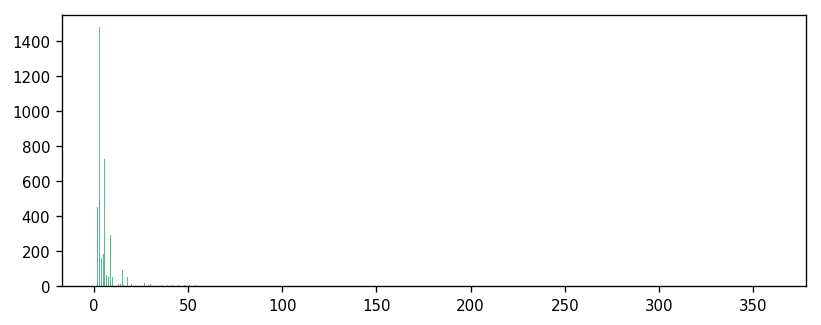

In [33]:
plot_histogram(num_frames)

In [38]:
# how many of these frames are more than 20 long? - only about 5%
sum(num > 20 for num in num_frames) / len(num_frames)

0.05249788314987299

## Select the sequences to be annotated
#### Start from no human-only and non-empty sequences. Exclude sequences longer than 20 frames, and exclude sequences with multiple species

In [92]:
df_seq_short = df_seq_animals[(df_seq_animals.num_frames <= 20)]

In [93]:
sum(df_seq_animals.num_frames)  # number of images
sum(df_seq_short.num_frames)

48204

34780

#### Separate out dog-walking, horse-riding, coyote/mule deer (two most common non-domestic species) sequences

In [94]:
df_seq_dog_walking = df_seq_short[df_seq_short.species == 'domestic dog;human']
len(df_seq_dog_walking)

2287

In [95]:
df_seq_horse_riding = df_seq_short[df_seq_short.species == 'domestic horse;human']
len(df_seq_horse_riding)

202

In [97]:
df_seq_coyote_deer = df_seq_short[(df_seq_short.species == 'coyote') | (df_seq_short.species == 'mule deer')]
len(df_seq_coyote_deer)
df_seq_coyote_deer.sample(n=3)

1713

,deployment_id,full_seq_id,is_daytime,is_empty,is_human_only,is_multi_species,num_frames,project_id,species,start_time
8547,d34720,datasetemammal.projectp158.deploymentd34720.se...,True,False,False,False,9,p158,mule deer,2016-11-21 17:36:43
7736,d34776,datasetemammal.projectp158.deploymentd34776.se...,False,False,False,False,3,p158,coyote,2017-01-03 22:35:32
16910,d34665,datasetemammal.projectp158.deploymentd34665.se...,False,False,False,False,6,p158,coyote,2017-06-15 02:19:22


#### Get ride of all multi-species (not that many after excluding dog walking and horse riding ones) sequences

In [99]:
def_single_species = df_seq_short[df_seq_short.is_multi_species == False]

In [102]:
df_seq_rare = def_single_species[(def_single_species.species != 'coyote') & (def_single_species.species != 'mule deer')]
len(df_seq_rare)
df_seq_rare.sample(n=5)

2492

,deployment_id,full_seq_id,is_daytime,is_empty,is_human_only,is_multi_species,num_frames,project_id,species,start_time
6367,d34667,datasetemammal.projectp158.deploymentd34667.se...,False,False,False,False,6,p158,bobcat,2016-08-03 22:15:56
9554,d34646,datasetemammal.projectp158.deploymentd34646.se...,True,False,False,False,3,p158,unknown animal,2016-07-21 17:29:08
15795,d23172,datasetemammal.projectp139.deploymentd23172.se...,True,False,False,False,5,p139,common raven,2016-01-22 11:46:22
18176,d34794,datasetemammal.projectp158.deploymentd34794.se...,False,False,False,False,3,p158,northern raccoon,2017-02-10 22:44:09
5640,d34740,datasetemammal.projectp158.deploymentd34740.se...,True,False,False,False,1,p158,domestic dog,2016-10-28 09:11:15


In [119]:
df_seq_coyote_deer_sample = df_seq_coyote_deer.sample(n=800)
len(df_seq_coyote_deer_sample)
df_seq_coyote_deer_sample.sample(n=3)

800

,deployment_id,full_seq_id,is_daytime,is_empty,is_human_only,is_multi_species,num_frames,project_id,species,start_time
18373,d21177,datasetemammal.projectp158.deploymentd21177.se...,False,False,False,False,6,p158,mule deer,2016-04-11 05:32:32
4855,d34640,datasetemammal.projectp158.deploymentd34640.se...,False,False,False,False,5,p158,coyote,2016-07-19 23:17:33
11834,d34709,datasetemammal.projectp158.deploymentd34709.se...,False,False,False,False,12,p158,mule deer,2016-10-04 00:18:49


In [120]:
df_seq_good = pd.concat([df_seq_rare, df_seq_coyote_deer_sample])
print('Total number of sequences: {}'.format(len(df_seq_good)))
print('Total number of images: {}'.format(sum(df_seq_good.num_frames)))
df_seq_good.sample(n=3)

Total number of sequences: 3292
Total number of images: 14867


,deployment_id,full_seq_id,is_daytime,is_empty,is_human_only,is_multi_species,num_frames,project_id,species,start_time
18206,d34794,datasetemammal.projectp158.deploymentd34794.se...,True,False,False,False,3,p158,mule deer,2017-02-25 09:10:28
1433,d34757,datasetemammal.projectp158.deploymentd34757.se...,False,False,False,False,4,p158,bobcat,2016-12-05 02:52:58
13643,d34779,datasetemammal.projectp158.deploymentd34779.se...,True,False,False,False,11,p158,coyote,2017-01-05 15:35:48


In [121]:
final_species = defaultdict(int)
for sp in df_seq_good.species:
    final_species[sp] += 1

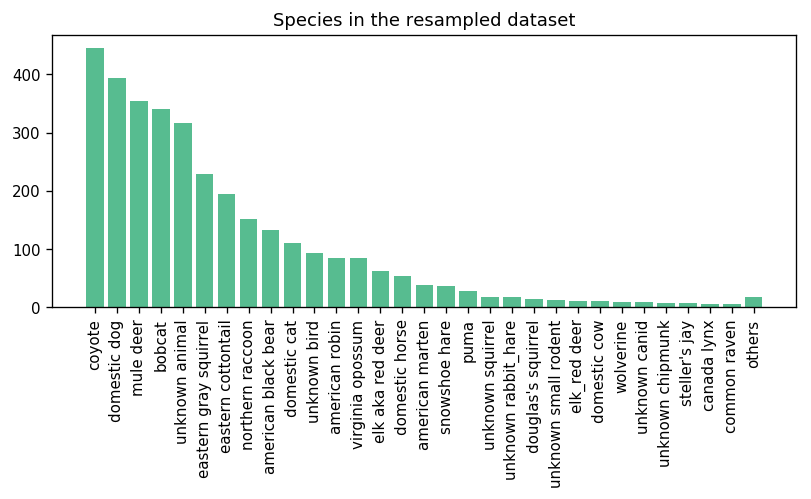

In [122]:
plot_distribution(final_species, title='Species in the resampled dataset', top=30)

#### Save a record of the sequences selected for relabeling 
Note that since the coyote and mule deer entries are sampled randomly, running this script again will NOT generate the same sequences

In [129]:
df_seq_good.to_csv('/home/yasiyu/yasiyu_temp/0RobertLong_sequences_20180907.csv', index=False)

In [128]:
# need to load df_seq_good from csv if you need to find the images in these sequences again.

#### Save a record of the images in the selected sequences

In [154]:
img_selected_paths = []
list_df_images_in_seq = []
for full_seq_id in tqdm(df_seq_good.full_seq_id):
    images_in_seq = df_img[df_img.full_seq_id == full_seq_id]
    
    pairs = zip(list(images_in_seq.full_img_path), list(images_in_seq.full_img_id))
    img_selected_paths.extend(pairs)
    
    list_df_images_in_seq.append(images_in_seq)

100%|██████████| 3292/3292 [00:22<00:00, 149.41it/s]


In [155]:
len(img_selected_paths)  # should be 14867

14867

In [153]:
df_img_good = pd.concat(list_df_images_in_seq)
len(df_img_good)
df_img_good.sample(n=3)

14867

,deployment_id,full_img_id,full_img_path,full_seq_id,img_id,project_id,project_name,site_name,species
17346,d34787,datasetemammal.projectp158.deploymentd34787.se...,/datadrive/emammal/p158d34787/d34787s277i2.JPG,datasetemammal.projectp158.deploymentd34787.se...,d34787s277i2,p158,Washington Urban-Wildland Carnivore Project,2786-5,unknown animal
31841,d34667,datasetemammal.projectp158.deploymentd34667.se...,/datadrive/emammal/p158d34667/d34667s74i5.JPG,datasetemammal.projectp158.deploymentd34667.se...,d34667s74i5,p158,Washington Urban-Wildland Carnivore Project,7650-1,bobcat
2561,d34701,datasetemammal.projectp158.deploymentd34701.se...,/datadrive/emammal/p158d34701/d34701s110i6.JPG,datasetemammal.projectp158.deploymentd34701.se...,d34701s110i6,p158,Washington Urban-Wildland Carnivore Project,4851-2,eastern gray squirrel


In [145]:
df_img_good.to_csv('/home/yasiyu/yasiyu_temp/0RobertLong_images_20180907.csv', index=False)

In [148]:
len(df_img_good.deployment_id.unique())  # number of deployments selected, out of a total of 126, so pretty good representation

121

#### Copy out the images into a folder

Need to rename the images to the full_img_id

In [156]:
img_selected_paths[14000]

('/datadrive/emammal/p158d34770/d34770s49i3.JPG',
 'datasetemammal.projectp158.deploymentd34770.seqd34770s49.frame0003.imgd34770s49i3')

In [157]:
dest_folder = '/home/yasiyu/yasiyu_temp/eMammal_20180907'
for from_path, full_img_id in tqdm(img_selected_paths):
    dest_path = os.path.join(dest_folder, '{}.jpg'.format(full_img_id))
    res = shutil.copyfile(from_path, dest_path)

100%|██████████| 14867/14867 [00:28<00:00, 512.75it/s]


In [ ]:
# zip the folder

In [160]:
# upload to blob storage - take a while
key = os.environ["AZ_STORAGE_KEY"]
blob_service = BlockBlobService(account_name='wildlifeblobssc', account_key=key) 
blob_service.create_blob_from_path('yasiyutemp', 'eMammal_20180907.zip', '/home/yasiyu/yasiyu_temp/eMammal_20180907.zip')

### Number of daytime/nighttime images

In [126]:
num_images_night = sum(df_seq_good[df_seq_good.is_daytime == False].num_frames) / sum(df_seq_good.num_frames)
num_images_night

0.5158404520078025

But if we take into account of all images including people walking dogs, there are now fewer nighttime pictures which makes sense since animals only come out after dark on trails / in general.

In [124]:
num_images_night_tot = sum(df_seq[df_seq.is_daytime == False].num_frames) / sum(df_seq.num_frames)
num_images_night_tot

0.21292366427715614